In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_to_multilabel_model, train_model_from_generators
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [6]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [7]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_esv.hd5',
            '--id', 'mri_slice_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-07-17 13:41:52,789 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_esv/log_2019-07-17_13-41_0.log.
2019-07-17 13:41:52,791 - arguments:185 - INFO - Command Line was:

python train --tensors /mnt/disks/pix-size-tensors/2019-04-29/ --input_tensors mri_slice --output_tensors end_systole_volume --batch_size 6 --epochs 2 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --model_file /mnt/ml4cvd/projects/jamesp/data/models/mri_slice_esv.hd5 --id mri_slice_esv


2019-07-17 13:41:52,793 - arguments:186 - INFO - Total TensorMaps:4404 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 12

2019-07-17 13:42:06,588 - tensor_generators:369 - INFO - Got first error: KeyError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 80, in multimodal_multitask_generator
    in_batch[tm.input_name()][stats['batch_index']] = tm.tensor_from_file(hd5, dependents)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 459, in tensor_from_file
    cur_slice = np.random.choice(list(hd5[MRI_TO_SEGMENT].keys()))
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/group.py", line 262, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 

(6, 256, 256, 1) (1, 256, 256, 1)


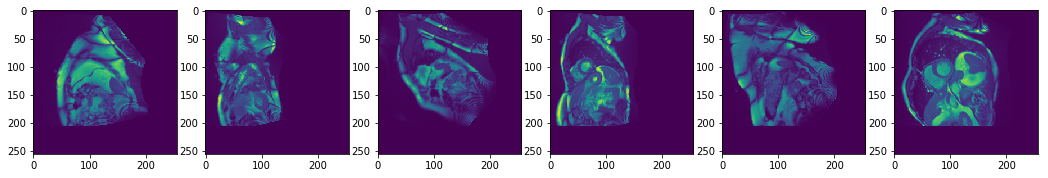

In [4]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [2.6422465  0.08675247 3.4849243  1.4032358  2.2749736  2.8981314 ] gradient shape: (6, 256, 256, 1)


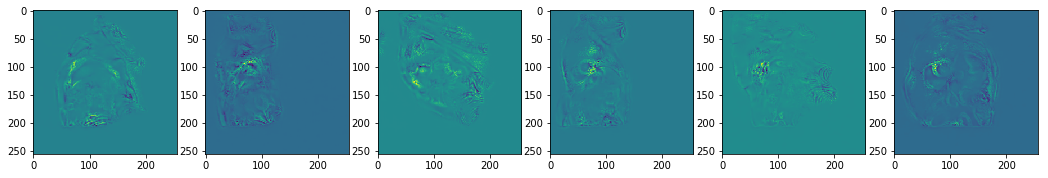

In [5]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [8]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'bmi',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_bmi.hd5',
            '--id', 'mri_slice_bmi']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-07-17 13:42:10,518 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_bmi/log_2019-07-17_13-42_0.log.
2019-07-17 13:42:10,519 - arguments:185 - INFO - Command Line was:

python train --tensors /mnt/disks/pix-size-tensors/2019-04-29/ --input_tensors mri_slice --output_tensors bmi --batch_size 6 --epochs 2 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --model_file /mnt/ml4cvd/projects/jamesp/data/models/mri_slice_bmi.hd5 --id mri_slice_bmi


2019-07-17 13:42:10,523 - arguments:186 - INFO - Total TensorMaps:4404 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329,

2019-07-17 13:42:28,414 - tensor_generators:369 - INFO - Got first error: KeyError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 80, in multimodal_multitask_generator
    in_batch[tm.input_name()][stats['batch_index']] = tm.tensor_from_file(hd5, dependents)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 459, in tensor_from_file
    cur_slice = np.random.choice(list(hd5[MRI_TO_SEGMENT].keys()))
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/usr/local/lib/python3.6/dist-packages/h5py/_hl/group.py", line 262, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 

(6, 256, 256, 1) (1, 256, 256, 1)


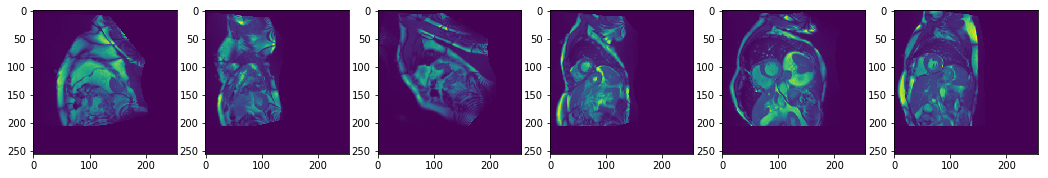

In [9]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [-0.00345858 -0.89663106 -0.68900275 -0.90861964 -0.7863489  -0.41515657] gradient shape: (6, 256, 256, 1)


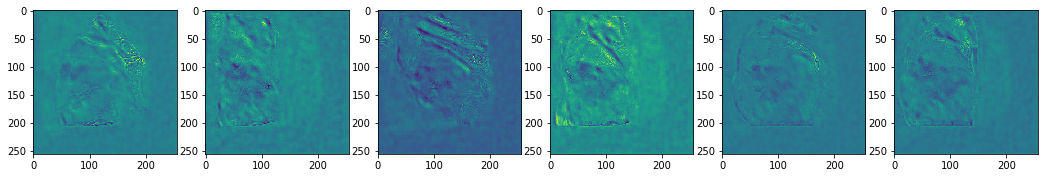

In [10]:
grads = saliency_map(test_tensor, model, 'output_23104_Body-mass-index-BMI_0_0_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'genetic_sex',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_sex.hd5',
            '--id', 'mri_slice_sex']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

In [ ]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_genetic_sex_categorical', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'birth_year',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_age.hd5',
            '--id', 'mri_slice_age']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

In [ ]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_22200_Year-of-birth_0_0_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_systole_diastole_esv.hd5',
            '--id', 'mri_systole_diastole_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)


In [ ]:
test_tensor = test_data['input_mri_systole_diastole']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(test_tensor[i, :, :, 0, 0])
    axes[1, i].imshow(test_tensor[i, :, :, 1, 0])
    

In [ ]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(grads[i, :, :, 0, 0])
    axes[1, i].imshow(grads[i, :, :, 1, 0])
    

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-text3/2019-04-26/', 
            '--input_tensors', 'ecg_rest_1lead', 
            '--output_tensors', 'ecg_rhythm',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/home/sam/ml/trained_models/ecg_1lead_rhythm_only/ecg_1lead_rhythm_only.hd5',
            '--id', 'ecg_1lead_rhythm_only']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

In [ ]:
test_tensor = test_data['input_strip_ecg_rest']
print(test_tensor.shape, test_tensor[3:4].shape)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
xdir = '/mnt/disks/ecg-text3/2019-04-26/'
paths = [xdir+'1238558.hd5', xdir+'1258475.hd5', xdir+'1286494.hd5', xdir+'1381627.hd5', 
         xdir+'1487911.hd5', xdir+'1509361.hd5', xdir+'1578315.hd5', xdir+'1616127.hd5', xdir+'1723645.hd5', ]
generator = TensorGenerator(8, args.tensor_maps_in, args.tensor_maps_out, paths, None, True)
data, labels, hd5s = next(generator)
print('predicitons are:', model.predict(data))

In [ ]:
test_tensor = data['input_strip_ecg_rest']
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 2)

In [ ]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 0)